**Importing the neccessary libraries!**

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix



**Loading the DataSet**

In [ ]:
# Load the dataset
data = pd.read_json('CETM47-23_24-AS2-Data.json')

In [ ]:
data.shape
#Understanding the the number of rows and columns in the dataset.

(6443, 5)

In [ ]:
data.head()
#Viewing the first 5 rows to grasp and get an insight of the dataset.This is very important as it would help to understand the dataset and inform the next step.

,text,date,label,id,label_name
0,The {@Clinton LumberKings@} beat the {@Cedar R...,2019-09-08,4,1170516324419866624,sports_&_gaming
1,I would rather hear Eli Gold announce this Aub...,2019-09-08,4,1170516440690176006,sports_&_gaming
2,"Someone take my phone away, I’m trying to not ...",2019-09-08,4,1170516543387709440,sports_&_gaming
3,"A year ago, Louisville struggled to beat an FC...",2019-09-08,4,1170516620466429953,sports_&_gaming
4,Anyone know why the #Dodgers #Orioles game nex...,2019-09-08,4,1170516711411310592,sports_&_gaming


In [ ]:
data['label_name'].value_counts()
#The label names counts would provide more insight on the labeling

label_name
pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: count, dtype: int64

**Data Preprocessing** 
*After gaining an insight , we need to preprocess the dataset by removing unnecessary things that would add or make the model better.*

In [ ]:
# Data Preparation
# Preprocessing function
import re
def preprocess_text(text):
    # Remove special characters, emojis, and URLs
    text = re.sub(r'\{@[^\}]+\}', '', text)  # Remove {@...@} mentions
    text = re.sub(r'\{{2}[^\}]+\}{2}', '', text)  # Remove {{...}} placeholders
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters except whitespace
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = text.lower()  # Convert text to lowercase
    return text.strip()  # Strip leading and trailing spaces

# Apply preprocessing to the 'text' column in the DataFrame
data['processed_text'] = data['text'].apply(preprocess_text)

# Display the preprocessed text
print(data['processed_text'].head())

0    the beat the in game of the western division f...
1    i would rather hear eli gold announce this aub...
2    someone take my phone away im trying to not lo...
3    a year ago louisville struggled to beat an fcs...
4    anyone know why the dodgers orioles game next ...
Name: processed_text, dtype: object


**Applying Stemming after preprocessing with REGEX to remove special characters, stop_words etc**
*I tried different experiment in the data preprocessing including lemmatization and Regex alone but stemming yielded the best metrics.*

In [ ]:
import nltk
from nltk.stem import PorterStemmer
nltk.download("punkt")
stemmer = PorterStemmer()
# Define a function to stem a single text
def stem_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stem each token
    stemmed_text = ' '.join(stemmed_tokens)  # Join the stemmed tokens back into a single text
    return stemmed_text

data['stemmed_text'] = data['processed_text'].apply(stem_text)

# Display the stemmed text
print(data['stemmed_text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['stemmed_text'], data['label'], test_size=0.2, random_state=42)

**Model and Pipeline**
*After splitting my dataset for training and testing, I need to build a model using logistics Regression, KNN and Gradient Boosting*

In [ ]:
# Define models with hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(), {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Optimization algorithm
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'clf__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
        'clf__weights': ['uniform', 'distance'],  # Weight function used in prediction
        'clf__metric': ['euclidean', 'manhattan']  # Distance metric
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'clf__n_estimators': [5, 10, 20, 25],  # Number of boosting stages
        'clf__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
        'clf__max_depth': [3, 5, 7] # Maximum depth of the individual trees
    })
}

# Results dictionary to store evaluation metrics
results = {}

# Dictionary to store confusion matrices
confusion_matrices = {}

# Loop over models
for name, (model, param_grid) in models.items():
    # Construct pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(stop_words='english')),  # Convert text to word count vectors
        ('tfidf', TfidfTransformer()),  # Apply TF-IDF transformation
        ('clf', model),  # Classifier
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Predictions
    y_pred = grid_search.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices[name] = cm

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store evaluation metrics
    results[name] = {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score']
    }

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Model Evaluation**

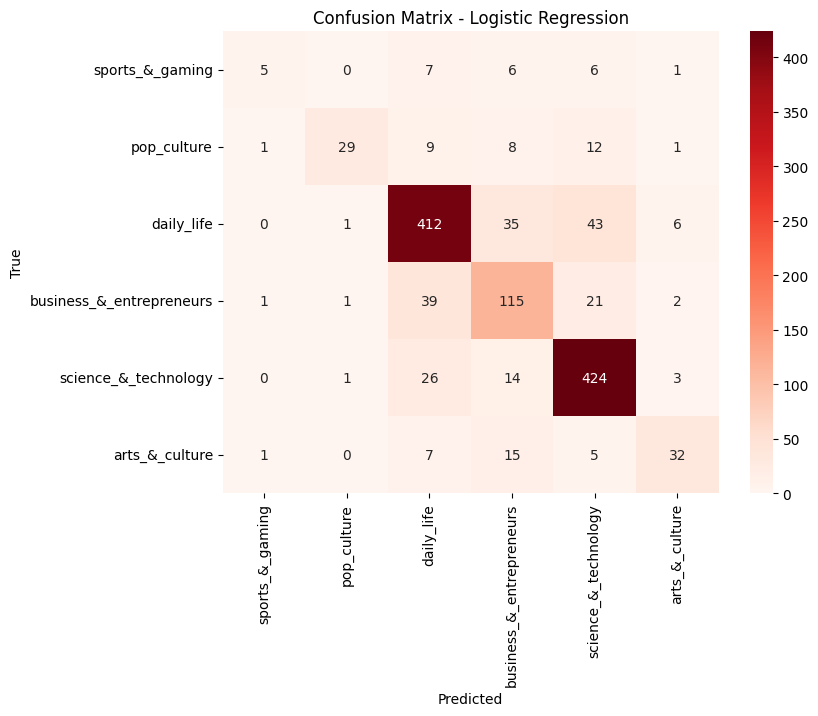

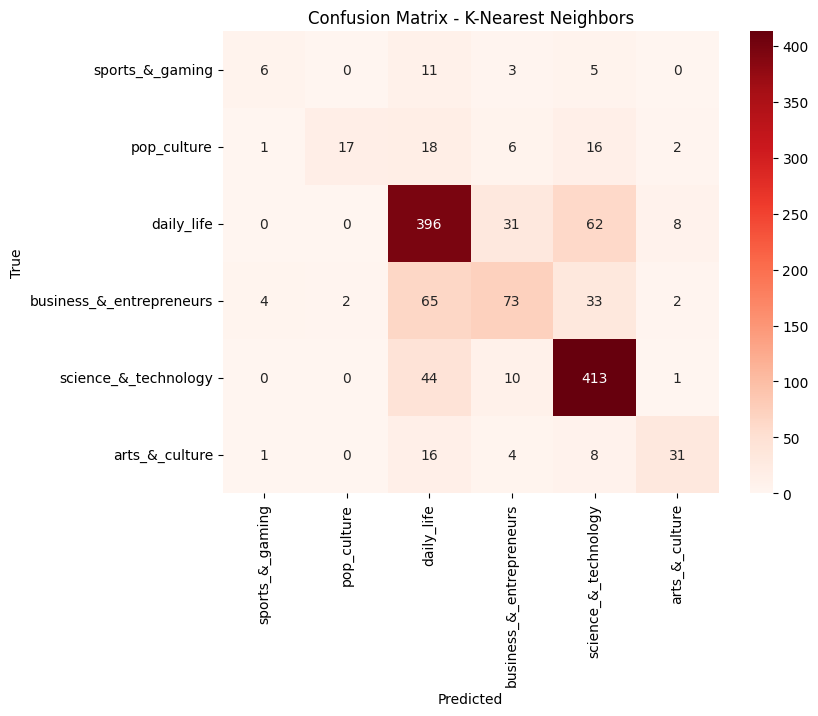

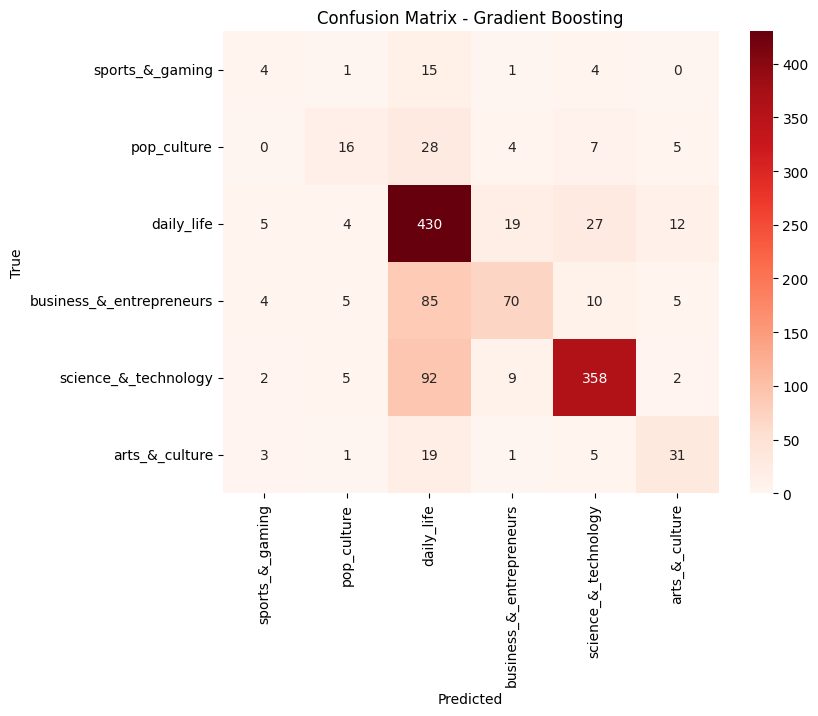

In [ ]:
# Visualize confusion matrices
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=data['label_name'].unique(), yticklabels=data['label_name'].unique())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

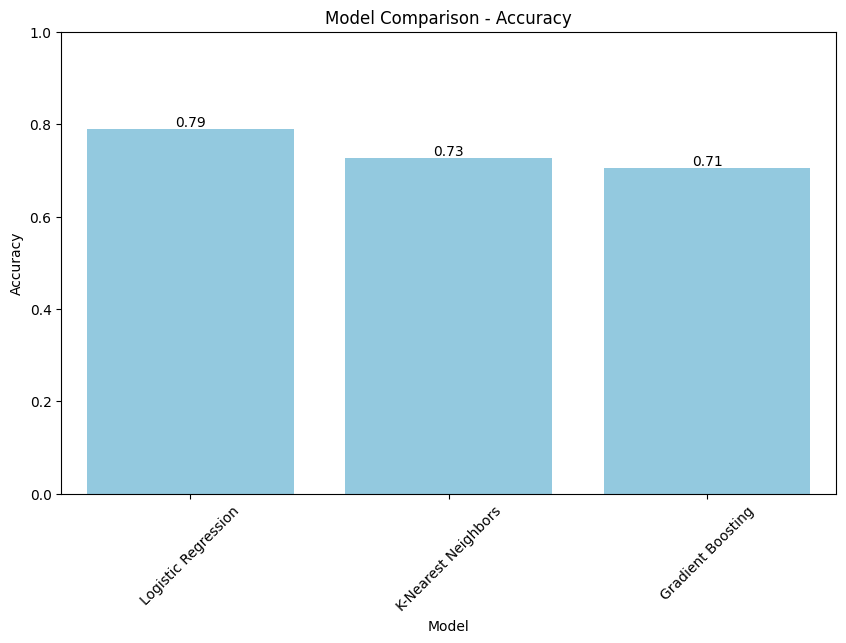

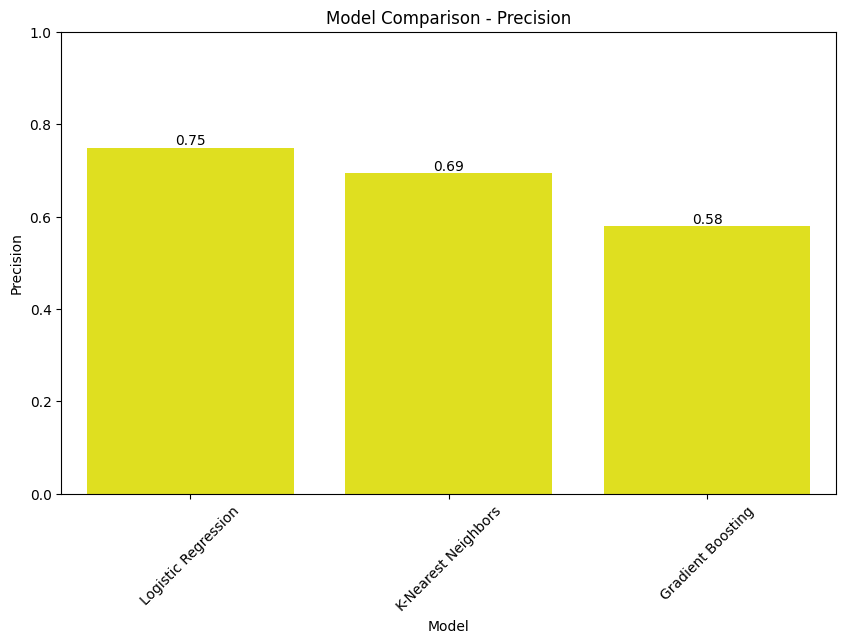

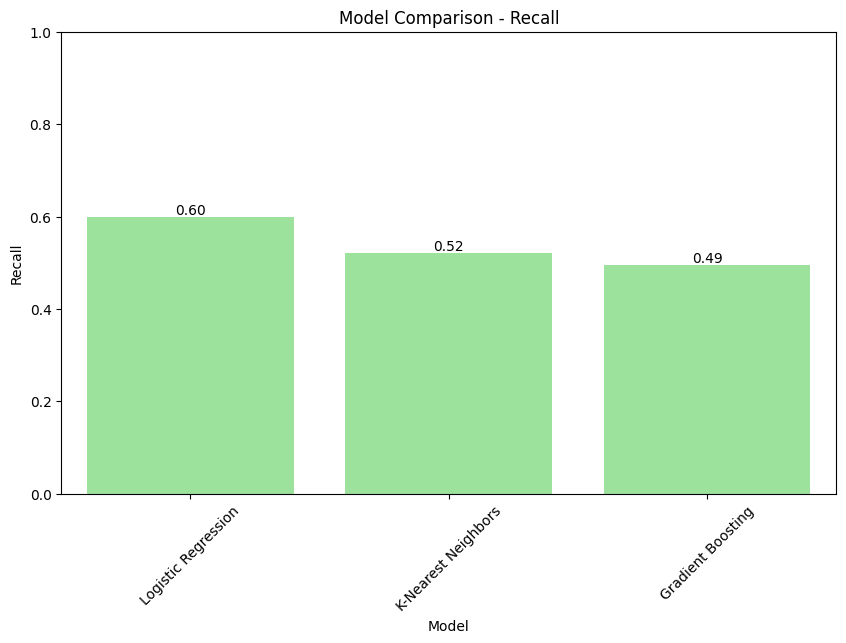

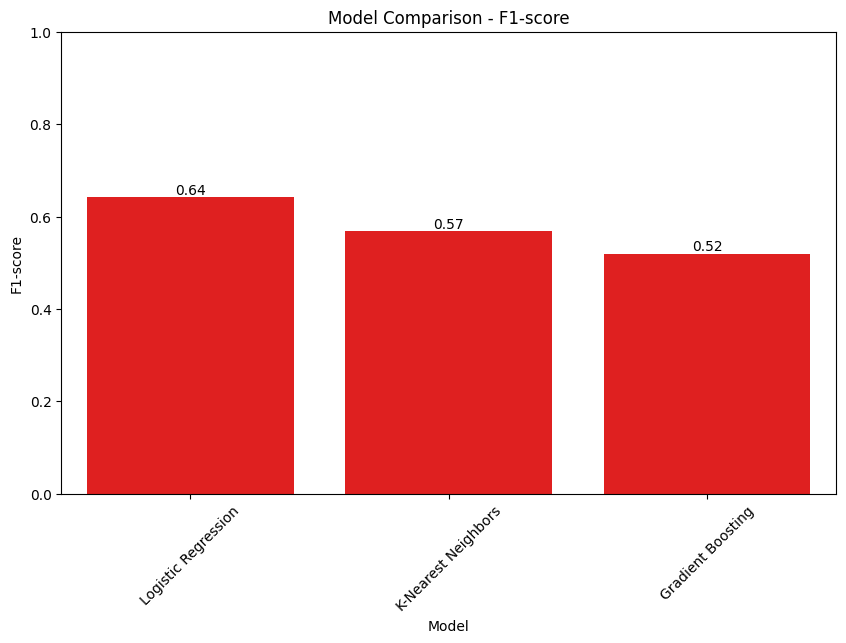

In [ ]:
# Plotting accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='accuracy', data=results_df, color='skyblue')
plt.title('Model Comparison - Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Accuracy')
for i, acc in enumerate(results_df['accuracy']):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')
plt.show()

# Plotting precision
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='precision', data=results_df, color='yellow')
plt.title('Model Comparison - Precision')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Precision')
for i, prec in enumerate(results_df['precision']):
    plt.text(i, prec, f'{prec:.2f}', ha='center', va='bottom')
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='recall', data=results_df, color='lightgreen')
plt.title('Model Comparison - Recall')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Recall')
for i, rec in enumerate(results_df['recall']):
    plt.text(i, rec, f'{rec:.2f}', ha='center', va='bottom')
plt.show()

# Plotting F1-score
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='f1-score', data=results_df, color='red')
plt.title('Model Comparison - F1-score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('F1-score')
for i, f1 in enumerate(results_df['f1-score']):
    plt.text(i, f1, f'{f1:.2f}', ha='center', va='bottom')
plt.show()